# 认识数据([赛题说明](https://2019ai.futurelab.tv/contest_detail/3#contest_des))
# 了解比赛的背景
属于回归问题  
评分函数：
$score=1-\frac{\sum_{i=1}^{m}\left(\hat{y}_{i}-y_{i}\right)^{2}}{\sum_{i=1}^{m}\left(y_{i}-\overline{y}\right)^{2}}$

# 数据分析及预处理

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [52]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_a.csv')

- info 方法：Print a concise summary of a DataFrame.  
    This method prints information about a DataFrame including  
    the index dtype and column dtypes, non-null values and memory usage.

In [53]:
print(df_train.info())

# 从pv 和 uv的条数可以发现有缺失

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 51 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

Text(0, 0.5, 'tradeMoney')

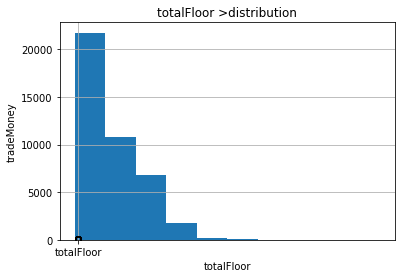

In [68]:
# boxplot查看每个特征下的数据分布
df_train.boxplot(column=['totalFloor'])
plt.hist(df_train['totalFloor'], bins = 10, range =(df_train['totalFloor'].min(),df_train['totalFloor'].max()))
plt.title('totalFloor >distribution')
plt.xlabel('totalFloor')
plt.ylabel('tradeMoney')

## 缺失值分析及处理  
### Take a first look at the data  

In [8]:
# 查看前5条
# print(df.head()) 

# set seed for reproducibility
np.random.seed(0) 

# 随机抽10条查看
print(df_train.sample(10))

              ID   area rentType houseType houseFloor  totalFloor houseToward  \
1927   100258818  79.00     未知方式    2室1厅1卫          高          13          南北   
18004  100114011  49.75     未知方式    2室1厅1卫          中           6           南   
25693  100067719  87.00     未知方式    2室1厅1卫          低          18           南   
27939  100055164  53.28     未知方式    1室1厅1卫          高           6           南   
36496  100008201  14.00       合租    3室1厅1卫          中           7           南   
14699  100146452  13.20       合租    3室1厅1卫          高           6           南   
32576  100029121  12.80       合租    4室1厅1卫          中           6           南   
16559  100124457  98.89     未知方式    2室2厅1卫          中          26           南   
20681  100096813  42.47     未知方式    1室1厅1卫          低          18           南   
30232  100042071  90.00       整租    1室2厅1卫          高          18           南   

      houseDecoration communityName city  ... landTotalPrice landMeanPrice  \
1927               其他       XQ

发现有很多缺失数据是以"未知方式"、"暂无数据"的形式存在的

### See how many missing data points we have  

In [11]:
# 查看每个column下直接缺失的数量
missing_values_count = df_train.isnull().sum()
print(missing_values_count)

ID                     0
area                   0
rentType               0
houseType              0
houseFloor             0
totalFloor             0
houseToward            0
houseDecoration        0
communityName          0
city                   0
region                 0
plate                  0
buildYear              0
saleSecHouseNum        0
subwayStationNum       0
busStationNum          0
interSchoolNum         0
schoolNum              0
privateSchoolNum       0
hospitalNum            0
drugStoreNum           0
gymNum                 0
bankNum                0
shopNum                0
parkNum                0
mallNum                0
superMarketNum         0
totalTradeMoney        0
totalTradeArea         0
tradeMeanPrice         0
tradeSecNum            0
totalNewTradeMoney     0
totalNewTradeArea      0
tradeNewMeanPrice      0
tradeNewNum            0
remainNewNum           0
supplyNewNum           0
supplyLandNum          0
supplyLandArea         0
tradeLandNum           0


In [23]:
# 查看每个column下以"未知方式"、"暂无数据"形式缺失的数量 (改进：能否直接以Series的形式表示出来)
dict={}
dict['rentType'] = list(df_train['rentType']).count("未知方式")
dict['houseToward'] = list(df_train['houseToward']).count("暂无数据")
dict['houseDecoration'] = list(df_train['houseDecoration']).count("其他")
dict['buildYear'] = list(df_train['buildYear']).count("暂无信息")
dict['pv'] = missing_values_count['pv']
dict['uv'] = missing_values_count['uv']
missing_values_count = pd.Series(dict)
print(missing_values_count)

rentType           30759
houseToward          963
houseDecoration    29040
buildYear           2808
pv                    18
uv                    18
dtype: int64


缺失值分析结果

In [22]:
# how many total missing values do we have?
print(df_train.shape,type(df.shape))

# percent of data that is missing
print('缺失率：')
print(missing_values_count/df_train.shape[(0)])

(41440, 51) <class 'tuple'>
缺失率：
rentType           0.742254
houseToward        0.023238
houseDecoration    0.700772
buildYear          0.067761
pv                 0.000434
uv                 0.000434
dtype: float64


### 分析出现缺失值的原因  
我们需要考虑的问题之一是：**某个数据的缺失是因为它没有被记录还是根本不存在？**  
如果一个数据值缺失是因为它根本不存在，那么我们就没有必要去猜它可能的值，我们需要做的就是让它继续为 NaN；如果一个数据值缺失是因为没有被记录，我们就应该基于与它同行同列的其他值，来猜想它的可能值。 


### Drop missing values  
如果急于做分析，可以采取的方案之一就是剔除掉任何包含缺失值的行或列。  
但这种方法是并不推荐，要想得到更好的分析结果，还是要先合理地处理缺失值。

In [25]:
# 由于所有项都是相同值所以舍去
df_train.drop('communityName',axis=1, inplace=True)
df_train.drop('city',axis=1,inplace=True)

print(df_train.shape)

(41440, 49)


### Filling in missing values  
除了剔除缺失值所在的行或者列，另一个方案是去补全缺失值自动补全缺失值

In [24]:
# 计算出缺失项的均值
mean = df_train[['pv','uv']].mean()

# 均值填充pv、uv
df_train = df_train.fillna(value=mean)

In [28]:
# bulidYear 用meidan中位数填充

df_train['rentType'][df_train['rentType']=='--'] = '未知方式'
# 转换object类型数据
columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
for col in columns:
    df_train[col] = df_train[col].astype('category')
        
# 将buildYear列转换为整型数据
tmp = df_train['buildYear'].copy()
tmp2 = tmp[tmp!='暂无信息'].astype('int')
print(len(tmp[tmp!='暂无信息']))
print(tmp2.median())
#  tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
tmp[tmp=='暂无信息'] = tmp2.median()
df_train['buildYear'] = tmp
df_train['buildYear'] = df_train['buildYear'].astype('int')


print(df_train.info())

41440
2002.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 49 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null category
houseType             41440 non-null object
houseFloor            41440 non-null category
totalFloor            41440 non-null int64
houseToward           41440 non-null category
houseDecoration       41440 non-null category
region                41440 non-null category
plate                 41440 non-null category
buildYear             41440 non-null int32
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum          41440 non-null int64
gymNum                41440 non-null int

D:\software\anaconda\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## 异常值分析处理
根据测试集数据的分布处理训练集的数据分布
### 使用合适的方法找出异常值
### 对异常值进行处理

## df.corr()

In [5]:
df.corr()

,ID,area,totalFloor,saleSecHouseNum,subwayStationNum,busStationNum,interSchoolNum,schoolNum,privateSchoolNum,hospitalNum,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney
ID,1.000000,0.003032,0.066104,0.066487,-0.209589,0.149062,0.068010,-0.060087,-0.118262,0.080632,...,0.091641,0.069468,0.049184,-0.076402,0.045793,0.015092,-0.064140,-0.197694,0.127877,-0.008343
area,0.003032,1.000000,0.082746,0.023909,-0.010355,0.033382,0.032986,-0.012624,-0.015293,-0.012392,...,0.016209,0.019631,0.013511,0.004930,0.022223,0.001592,0.012173,0.034391,0.009286,0.006719
totalFloor,0.066104,0.082746,1.000000,0.010170,0.006422,0.053091,-0.051045,-0.020157,-0.059855,0.035029,...,-0.004290,-0.017954,-0.017011,0.178294,0.029101,0.022682,0.097928,0.070085,-0.000028,0.006358
saleSecHouseNum,0.066487,0.023909,0.010170,1.000000,-0.026399,0.031629,-0.007285,-0.017954,0.032270,-0.012456,...,0.065817,0.083181,0.096914,-0.041772,0.076490,0.017066,-0.140116,-0.097992,0.177540,0.000391
subwayStationNum,-0.209589,-0.010355,0.006422,-0.026399,1.000000,0.252314,-0.026975,0.643900,0.188826,0.573360,...,-0.017522,-0.003857,0.009712,0.212760,0.154487,0.549301,0.233920,0.319362,-0.002066,-0.000733
busStationNum,0.149062,0.033382,0.053091,0.031629,0.252314,1.000000,0.297939,0.558335,0.047329,0.613182,...,0.334577,0.137075,0.138972,-0.057569,0.016074,0.845071,0.405936,0.389930,0.005901,-0.004737
interSchoolNum,0.068010,0.032986,-0.051045,-0.007285,-0.026975,0.297939,1.000000,0.133932,0.139548,0.181332,...,0.121680,0.093815,0.125085,0.040155,0.032677,0.153226,0.038747,0.017269,-0.000074,0.007757
schoolNum,-0.060087,-0.012624,-0.020157,-0.017954,0.643900,0.558335,0.133932,1.000000,0.443438,0.775448,...,0.116114,0.022003,0.041300,0.202449,0.167598,0.780225,0.254587,0.298972,0.007413,0.000568
privateSchoolNum,-0.118262,-0.015293,-0.059855,0.032270,0.188826,0.047329,0.139548,0.443438,1.000000,0.097900,...,-0.011380,-0.044983,-0.011327,0.227847,0.094423,0.300599,0.096464,0.145441,0.014583,0.006595
hospitalNum,0.080632,-0.012392,0.035029,-0.012456,0.573360,0.613182,0.181332,0.775448,0.097900,1.000000,...,0.149749,0.039733,0.069129,-0.045273,0.085045,0.754047,0.303874,0.304323,-0.007191,-0.004456


## 特征值分析
1. 是否有单调特征列(单调的特征列很大可能是时间)   
待补充

## 特征nunique分布
  1. 出现在测试集中的community，但是在训练集中数量较少
  

In [4]:
# 训练集中的community
print(df['communityName'].nunique())
print('-'*32)

# 测试集中的community
print(df_test['communityName'].nunique())

4236
--------------------------------
2469


2. 统计object类型的特征值出现频次大于100的特征  

In [15]:
for cols in df.columns:
    if df[cols].nunique()>100 and df[cols].dtype=='object':
        print(cols)

houseType
communityName
tradeTime


## Label分布
  1. 不同的特征值的样本的label的分布

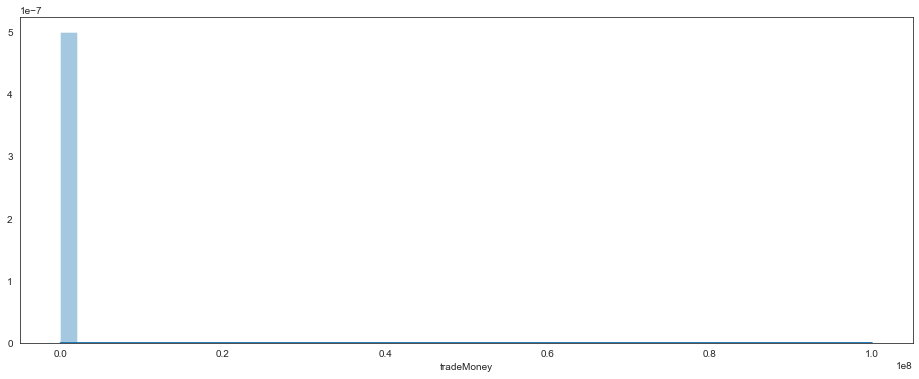

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(df['tradeMoney'])

In [19]:
# 筛选数据后再进行观察
num = len(df.index)

for i in range(1, 10):
    s = i*10000
    print('{:<6}: {:.5f}'.format(s, len(df[df['tradeMoney'] < s]) / num))

10000 : 0.93316
20000 : 0.98625
30000 : 0.99534
40000 : 0.99771
50000 : 0.99831
60000 : 0.99889
70000 : 0.99908
80000 : 0.99930
90000 : 0.99944


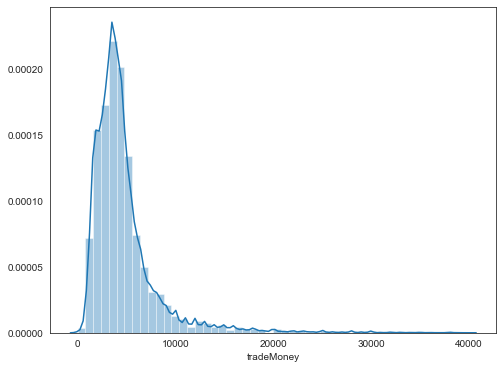

In [20]:
df = df[df['tradeMoney'] < 40000]

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['tradeMoney'])

# 深度清洗
## 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗

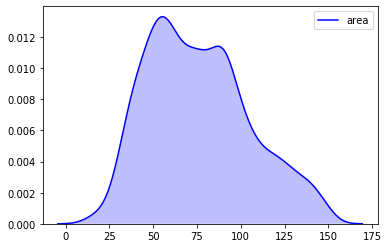

In [38]:
#特征存储类型为object类型
f1 = df_train.dtypes[df_train.dtypes=='object'].index
#连续性类型特征
f2 = df_train.dtypes[df_train.dtypes!='object'].index
#测试集area分布
sns.kdeplot(df_test['area'], color="Blue", shade= True)

In [34]:
df_train = df_train[(df_train['area']<=175)&(df_train['area']>10)]
df_train = df_train[df_train['tradeMoney']<=20000]

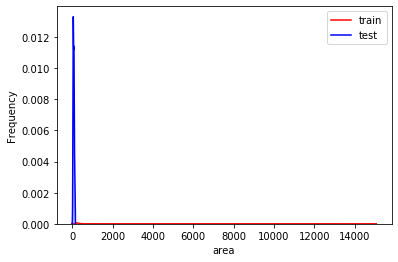

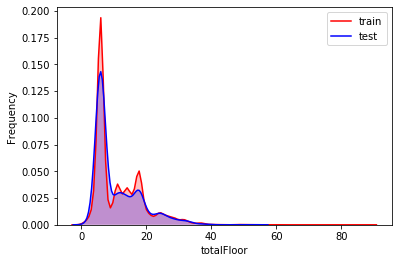

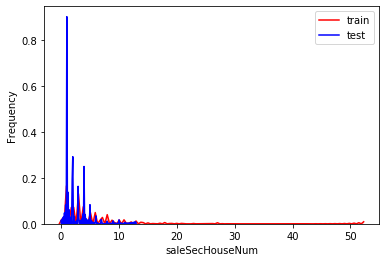

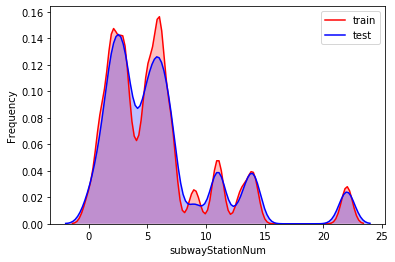

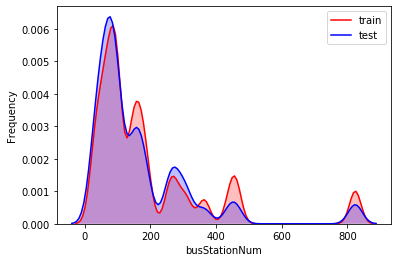

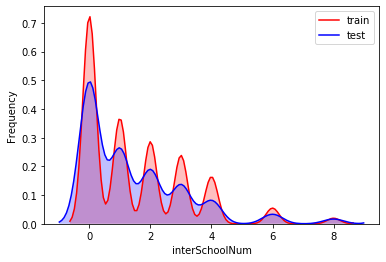

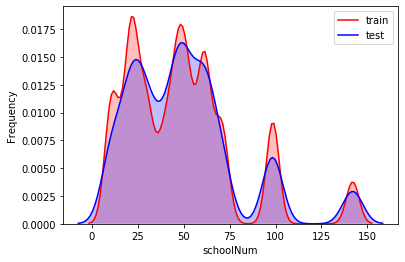

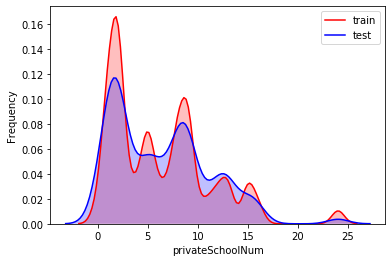

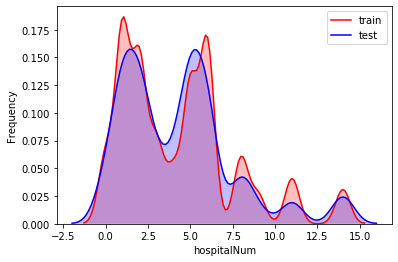

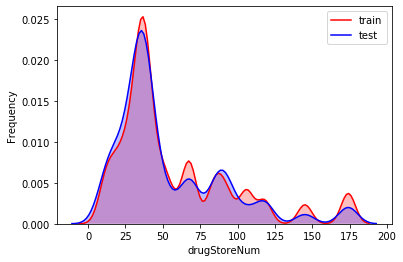

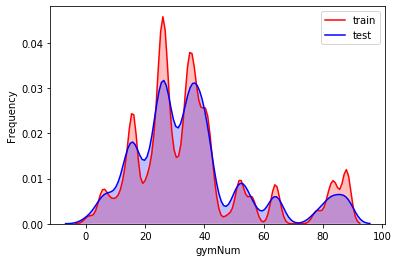

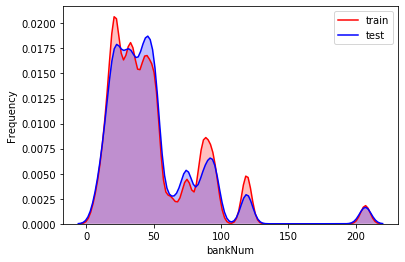

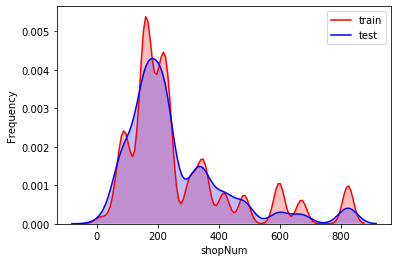

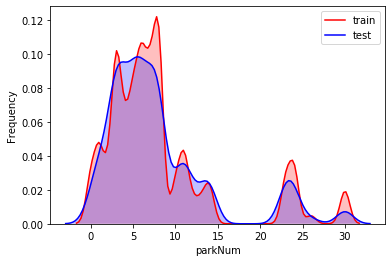

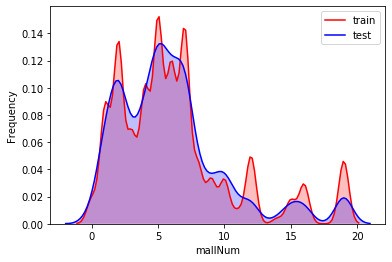

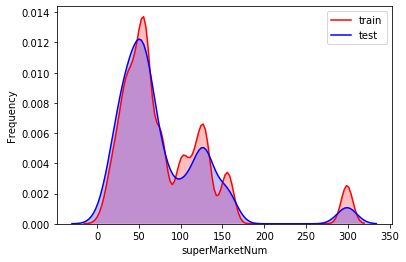

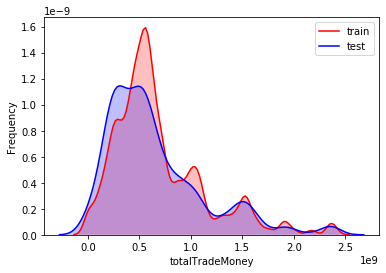

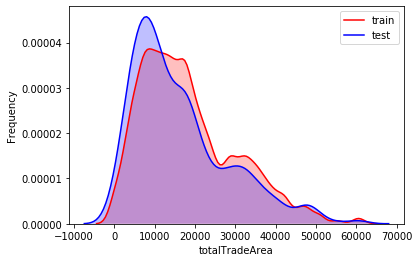

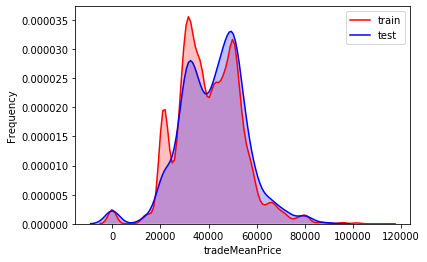

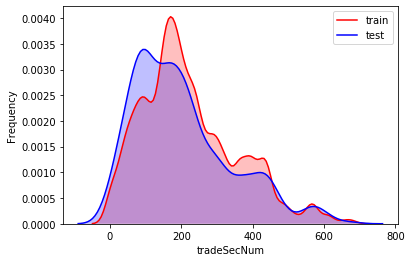

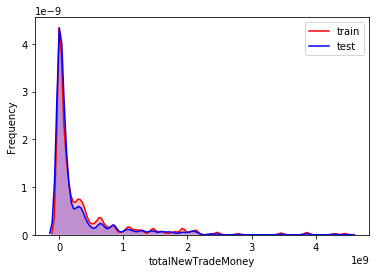

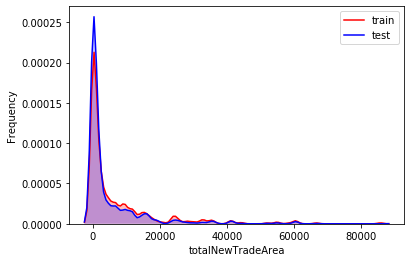

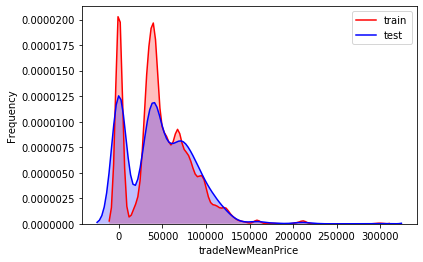

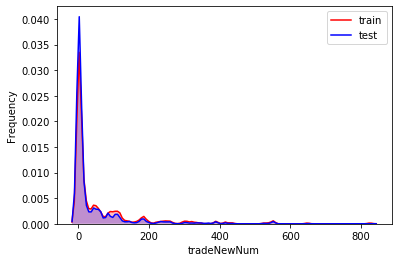

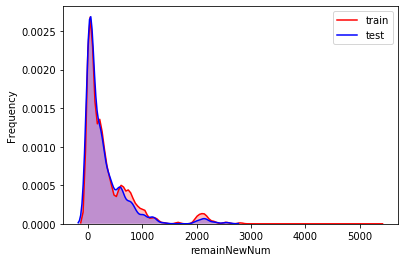

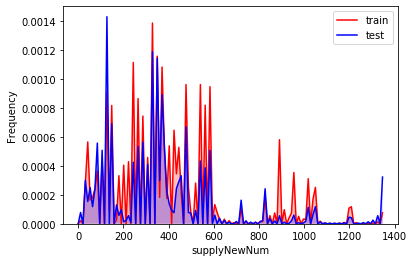

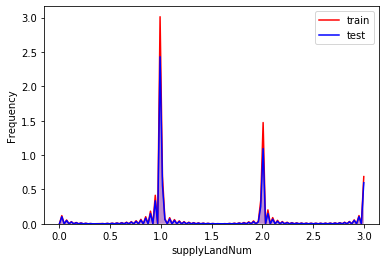

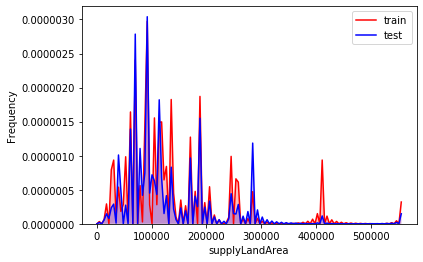

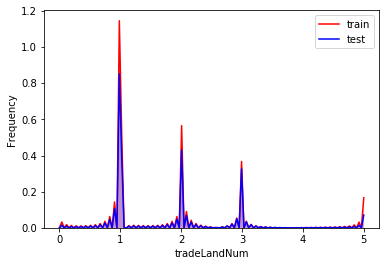

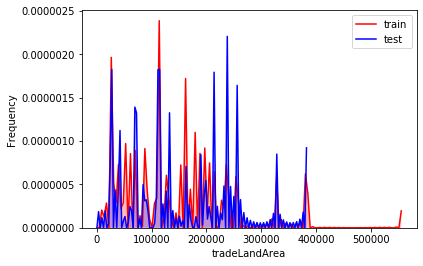

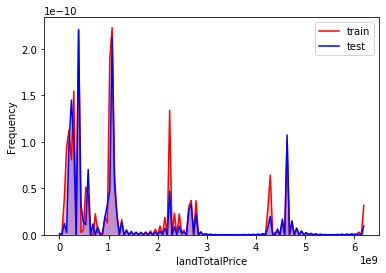

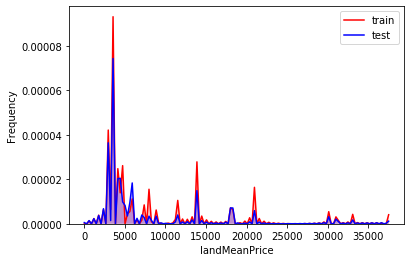

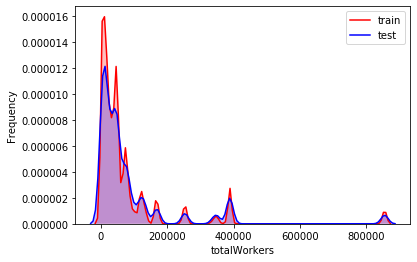

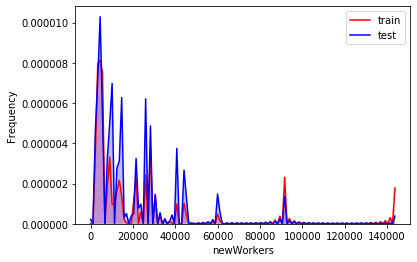

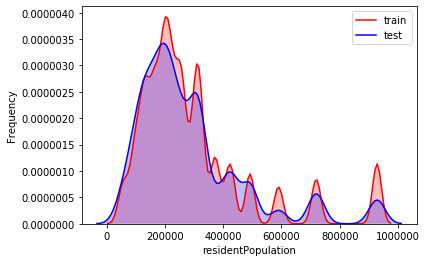

D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\software\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


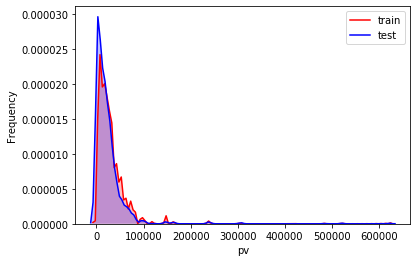

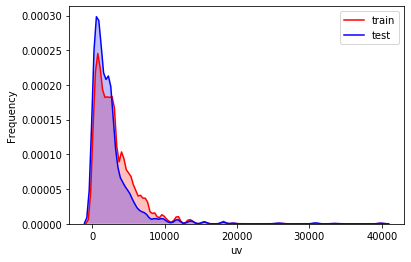

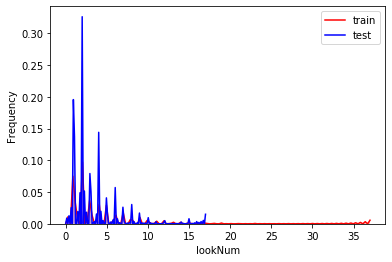

In [39]:
#查看连续变量在训练集和测试集的分布
features = [i for i in f2 if i not in ['ID','tradeMoney']]
for column in features:
    g = sns.kdeplot(df_train[column], color="Red", shade = True)
    g = sns.kdeplot(df_test[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

D:\software\anaconda\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\software\anaconda\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


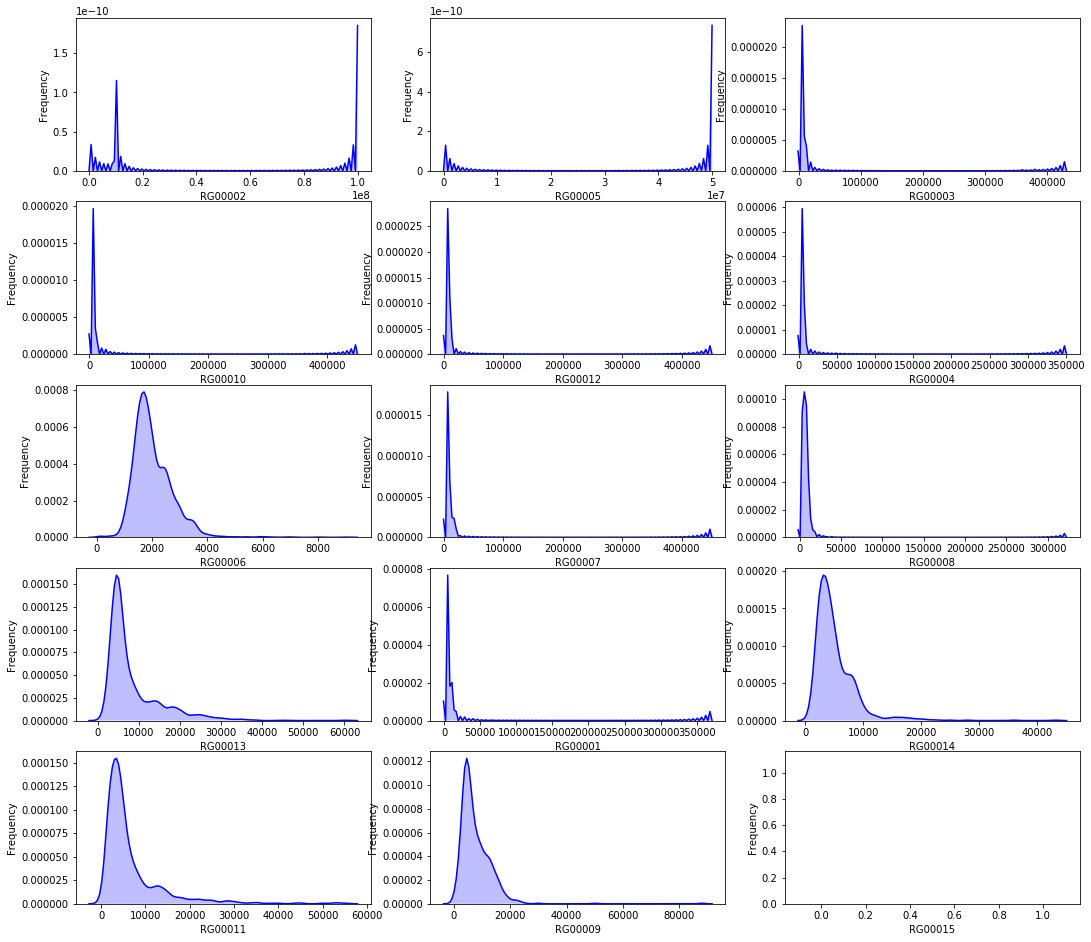

In [42]:
#每个region 对应的交易金额分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,50))
for i,val in enumerate(df_train.region.value_counts().index,1):
    plt.subplot(len(df_train.region.value_counts().index), 3, i)
    g= sns.kdeplot(df_train[df_train['region']==val]['tradeMoney'].values,  color="Blue", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
#     plt.show()

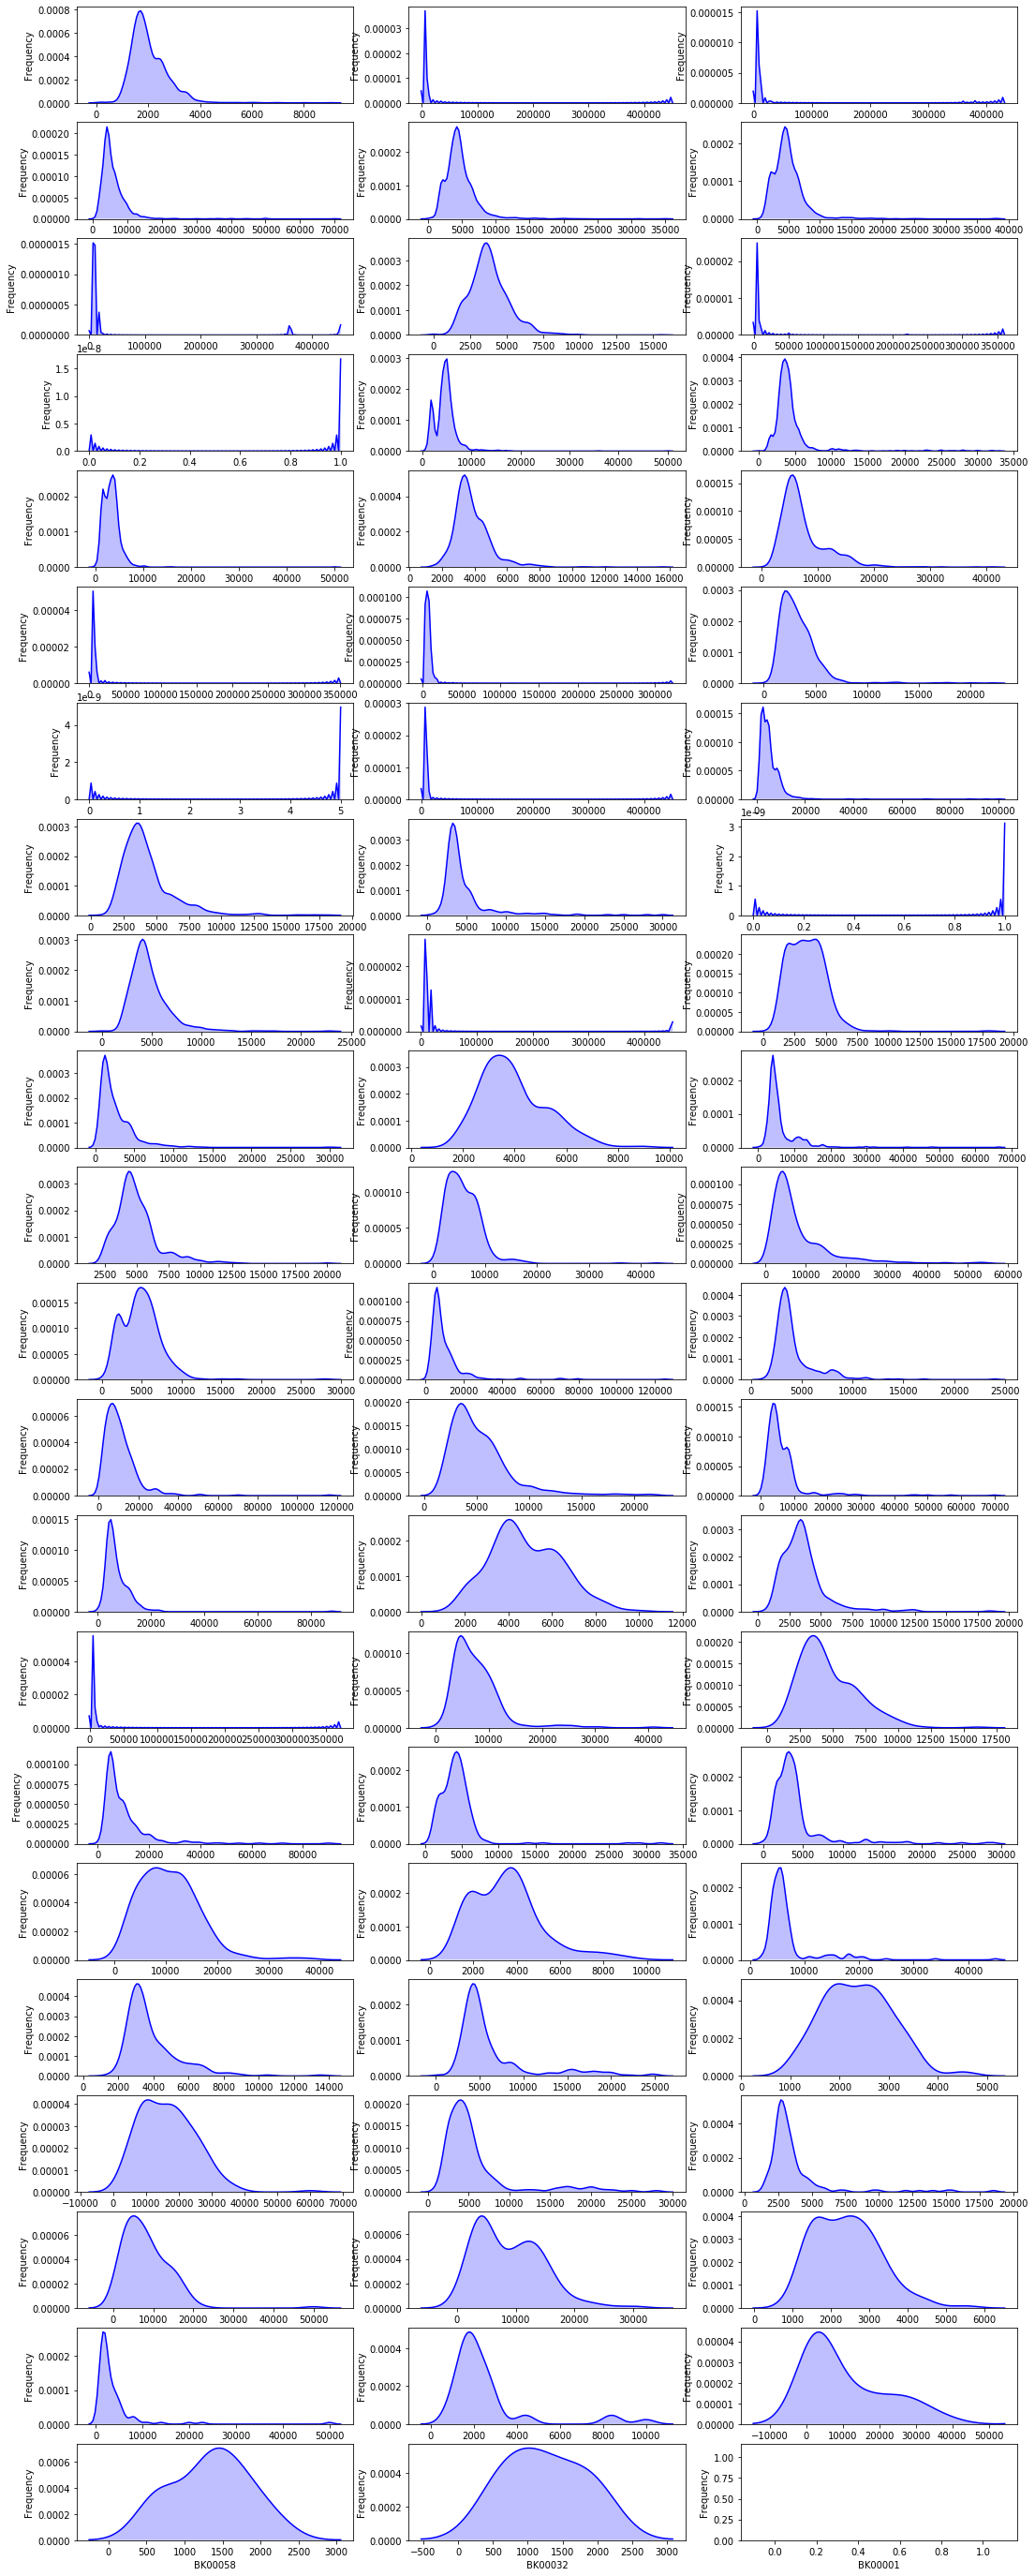

In [43]:
#每个plate对应的交易金额的分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,150))
for i,val in enumerate(df_train.plate.value_counts().index,1):
    plt.subplot(len(df_train.plate.value_counts().index), 3, i)
    g= sns.kdeplot(df_train[df_train['plate']==val]['tradeMoney'].values,  color="Blue", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
#     plt.show()